In [1]:
import tensorflow as tf
import numpy as np
import os
from scipy.io import loadmat

import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Dropout, Flatten, Activation
from tensorflow.keras.layers import Conv2D, LeakyReLU
from tensorflow.keras.utils import plot_model

train_data_path = '/home/zhaohengguo/Desktop/VMI_Codes_8_by_8/Training_Data/0603/'

In [2]:
def scale_vector_potential(Up):
    """We use this fucntion to scale the vector potential into a number between [-1,1].
    This is benefit the training process of out CNN model which uses tanh as the nonlinear activation
    of the last fully-connected layer.
    Input:
    Up: A N-by-1 array. The ponderomotive energy of the laser field.
    Output:
    A_streaking_scale: A N-by-1 array. The amplitude of the vector potential of the laser field. Each number
    is within [-1, 1].
    A_range: [A_min, A_max], where both A_min and A_max are in the atomic unit. They will be used to reconstruct
    the physical vector potential of the laser field from the output of out model.
    """
    
    A_streaking = np.sqrt(Up)
    A_range = [np.min(A_streaking), np.max(A_streaking)]
    
    A_aver = (np.max(A_streaking)+np.min(A_streaking))/2
    
    A_streaking_scale = 2*(A_streaking-A_aver)/np.ptp(A_streaking)
    
    return A_streaking_scale, A_range

def reconstruct_vector_potential(A_out_scale, A_range):
    """We use this function to reconstruct the physical vector potential of 
    the laser field from the output of out model.
    Input:
    A_out: A N-by-1 array. The amplitude of the vector potential of the laser field. Each number
    is within [-1, 1].
    A_range: [A_min, A_max], where both A_min and A_max are in the atomic unit.
    Output:
    A_recon: A N-by-1 array. The physical vector potential of the laser pulse.
    """
    A_min = A_range[0]
    A_max = A_range[1]
    A_aver = (A_min+A_max)/2
    A_range = (A_max-A_min)
    
    A_recon = A_aver + 0.5*A_out_scale
    
    return A_recon

def scale_P2D(P2D):
    """We use this function to rescale the 2D momentum distribution of ionized photoelectrons.
    Input:
    P2D: A N-by-1024 array.
    Output:
    P2D_scale: A N-by-32-by-32-by-1 array."""
    
    P2D = (P2D.T/np.max(P2D, axis = 1).T).T
    P2D_scale = P2D.reshape([-1,32,32,1])
    
    return P2D_scale
    
    
    

In [3]:
P2D = loadmat(train_data_path+'P2D_train_737576.mat')['P2D_train']
Up = loadmat(train_data_path+'Up_train_737576.mat')['Up_train']
A_streaking_scale, A_range = scale_vector_potential(Up) # The amplitude of the vector potential of the streaking laser

In [4]:
N_data = np.shape(P2D)[0]
N_val = 400
N_train = N_data-N_val

# Split the data set into the training data set and the test data set
# The training data set
P2D_train_scale = scale_P2D(P2D[0:N_train, :])
A_train_scale = A_streaking_scale[0:N_train, :]

# The test data set
P2D_val_scale = scale_P2D(P2D[-N_val:, :])
A_val_scale = A_streaking_scale[-N_val:, :]

## Build the CNN to reconstruct the pondermotive energy of the streaking laser from each VMI image

In [5]:
def vector_potential_generator(VMI_dim):
    """Generate images from a VIM image of size input_dim.
    
    Inputs:
    - z: TensorFlow Tensor of VMI images with shape [batch_size, VMI_dim**2]
    
    Returns:
    TensorFlow Tensor of generated vector potentials, with shape [batch_size, 1].
    """
    model = Sequential([
        Conv2D(64, kernel_size=(4, 4), activation='tanh', input_shape=(VMI_dim, VMI_dim,1)),
        
        Dropout(0.25),
        
        Conv2D(32, (3, 3), activation='tanh'),
        
        Dropout(0.25),
        
        Conv2D(16, (3, 3), activation='tanh'),
        
        Flatten(),
        
        Dense(100, activation='tanh'),
        
        Dropout(0.25),
        
        Dense(1, activation='tanh')

    ])
    return model

In [6]:
model = vector_potential_generator(32)

adam_opt = tf.keras.optimizers.Adam(lr = 0.0001, beta_1=0.9, beta_2=0.999, decay=1e-6)
model.compile(loss='mean_squared_error',optimizer=adam_opt)

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [7]:
history = model.fit(P2D_train_scale, A_train_scale, epochs=30, batch_size=200, shuffle=True, validation_data = (P2D_val_scale,A_val_scale))

Train on 19600 samples, validate on 400 samples
Instructions for updating:
Use tf.cast instead.
Epoch 1/30
19600/19600 [==============================] - 32s 2ms/sample - loss: 0.0135 - val_loss: 0.0028
Epoch 2/30
19600/19600 [==============================] - 31s 2ms/sample - loss: 0.0066 - val_loss: 0.0024
Epoch 3/30
19600/19600 [==============================] - 31s 2ms/sample - loss: 0.0052 - val_loss: 0.0023
Epoch 4/30
19600/19600 [==============================] - 31s 2ms/sample - loss: 0.0046 - val_loss: 0.0024
Epoch 5/30
19600/19600 [==============================] - 31s 2ms/sample - loss: 0.0042 - val_loss: 0.0022
Epoch 6/30
19600/19600 [==============================] - 31s 2ms/sample - loss: 0.0039 - val_loss: 0.0022
Epoch 7/30
19600/19600 [==============================] - 30s 2ms/sample - loss: 0.0038 - val_loss: 0.0022
Epoch 8/30
19600/19600 [==============================] - 31s 2ms/sample - loss: 0.0036 - val_loss: 0.0022
Epoch 9/30
19600/19600 [========================

In [8]:
model.save('Model_A_Recon')

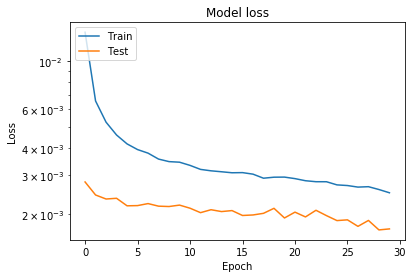

In [9]:
# Plot training & validation loss values
plt.semilogy(history.history['loss'])
plt.semilogy(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train', 'Test'], loc='upper left')
plt.savefig('train_err_A.eps')
plt.show()

## Test our model on the test data set

In [10]:
test_data_path = '/home/zhaohengguo/Desktop/VMI_Codes_8_by_8/Training_Data/0604/'

In [11]:
P2D_test = loadmat(test_data_path+'P2D_train_737580.mat')['P2D_train']
Up_test = loadmat(test_data_path+'Up_train_737580.mat')['Up_train']
A_test = np.sqrt(Up_test[0,0]) # The amplitude of the vector potential of the streaking laser
P2D_test_scale = scale_P2D(P2D_test)

In [12]:
A_out_scale = model.predict(P2D_test_scale)

In [13]:
A_output = reconstruct_vector_potential(A_out_scale, A_range)

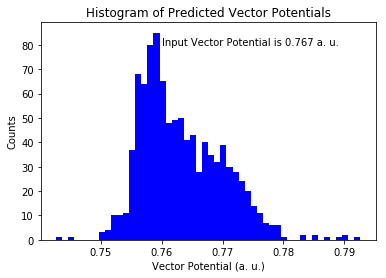

In [18]:
n, bins, patches = plt.hist(np.ravel(A_output), 50, facecolor='b')


plt.xlabel('Vector Potential (a. u.)')
plt.ylabel('Counts')
plt.title('Histogram of Predicted Vector Potentials')
plt.text(0.76, 80, r'Input Vector Potential is 0.767 a. u.')
plt.savefig('hist_test_A.eps')
plt.show()

In [15]:
model.save('Model_A_Recon')

In [16]:
plot_model(model, to_file='model_A.png',show_shapes=True, show_layer_names=True)